# Tropical Cyclone forecast

This notebook demonstrates how to use the Prithvi-WxC model to perform global weather forecasts. The specific case we will be looking at is the evolution of Hurricane Ida August 27 to September 2.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Input data

We will initialize the forecast at 0Z on August 2021-08-27. To perform long-range forecasts with the Prithvi-WxC model, we need to unroll the model. That means we will perform multiple forecasts reusing the predicted state as input for the next forecast. For this we will need static input data as well as climatology data for all intermediate forecast steps. We can download all required data using the ``get_prithvi_wxc_input`` function.

> **Note:** To download the data you will need your NASA EarthData account again. Please see the ``PrithviWxC_input_data.ipynb`` notebook for instruction on how to do this.

In [2]:
import numpy as np
from PrithviWxC.download import get_prithvi_wxc_input

initialization_time =np.datetime64("2021-08-27")
get_prithvi_wxc_input(
    initialization_time,
    6, # The time difference in hours between consecutive model steps.
    6 * 24, # Total maximum lead time.
    "../data/merra-2",
    "../data/"
)

/home/simon/miniforge3/envs/fm4a/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GES DISC username:  pansat
GES DISC password:  ········


Extracting input data: 100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [06:31<00:00, 48.98s/it]


## Loading the input data

To load the input data for the roll-out forecast, we use the ``Merra2RolloutDataset``.

In [4]:
from PrithviWxC.configs import get_model_config
from PrithviWxC.dataloaders.merra2_rollout import Merra2RolloutDataset

# Workshop participants can use the 'small' Prithvi-WxC model
# Remote users will need to use 'large_rollout'.
config_name = "small"
prithvi_config = get_model_config(config_name, data_dir="../../data")

dataset = Merra2RolloutDataset(
    time_range=("2021-08-26", "2021-09-18"),
    lead_time=96,
    input_time=-6,
    data_path_surface="../data/merra-2",
    data_path_vertical="../data/merra-2",
    climatology_path_surface="../data/climatology",
    climatology_path_vertical="../data/climatology",
    surface_vars=prithvi_config.surface_vars,
    static_surface_vars=prithvi_config.static_surface_vars,
    vertical_vars=prithvi_config.vertical_vars,
    levels=prithvi_config.levels,
    positional_encoding="fourier",
)
assert 0 < len(dataset), "There doesn't seem to be any valid data."

(True, "There doesn't seem to be any valid data.")

## Loading the model

In the cell below we first create the model instance and then load the pre-trained weights.

In [5]:
import torch
from PrithviWxC.configs import load_model

config_name = "small"
device = "cuda" if torch.cuda.is_available() else "cpu"

if config_name == "large":
    model = load_model(config_name, data_dir="../data", load_weights=True)
else:
    model = load_model(config_name, data_dir="../data", load_weights=False)
    weights_path = "../data/weights/prithvi.wxc.rollout.600m.v1.pt"
    state_dict = torch.load(weights_path, weights_only=False)
    if "model_state" in state_dict:
        state_dict = state_dict["model_state"]
    model.load_state_dict(state_dict, strict=True)
    
if (hasattr(model, "device") and model.device != device) or not hasattr(
    model, "device"
):
    model = model.to(device)

## Running the forecast

To perform forecasts that extend over several days with the Prithvi-WxC model, we need to unroll the model. That means the forecast is produced by repeatedly forcasting the next atmospheric state with a fixed, given lead time, and reusing the resulting forecasted state to forecast the next state. Since the ``Prithvi-WxC`` package provides a function that perform the unrolling for us, we don't need to worry to much about the details.

In [6]:
import torch
from torch import Tensor, nn


def rollout_iter(
    nsteps: int,
    model: nn.Module,
    batch: dict[str, Tensor | int | float],
    return_intermediate: bool = False
) -> Tensor:
    """A helper function for performing autoregressive rollout.

    Args:
        nsteps (int): The number of rollout steps to take
        model (nn.Module): A model.
        batch (dict): A data dictionary common to the Prithvi models.

    Raises:
        ValueError: If the number of steps isn't positive.

    Returns:
        Tensor: the output of the model after nsteps autoregressive iterations.
    """
    if nsteps < 1:
        raise ValueError("'nsteps' shouold be a positive int.")

    xlast = batch["x"][:, 1]
    batch["lead_time"] = batch["lead_time"][..., 0]

    # Save the masking ratio to be restored later
    mask_ratio_tmp = model.mask_ratio_inputs

    preds = []

    for step in range(nsteps):
        # After first step, turn off masking
        if step > 0:
            model.mask_ratio_inputs = 0.0

        batch["static"] = batch["statics"][:, step]
        batch["climate"] = batch["climates"][:, step]
        batch["y"] = batch["ys"][:, step]

        out = model(batch)
        if return_intermediate:
            preds.append(out.cpu().numpy())

        batch["x"] = torch.cat((xlast[:, None], out[:, None]), dim=1)
        xlast = out

    # Restore the masking ratio
    model.mask_ratio_inputs = mask_ratio_tmp

    if return_intermediate:
        return preds

    return out


In [7]:
import torch
from PrithviWxC.dataloaders.merra2_rollout import preproc

padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}
data = next(iter(dataset))
batch = preproc([data], padding)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    forecast = rollout_iter(dataset.nsteps, model, batch, return_intermediate=True)
valid_times = initialization_time + np.timedelta64(6, "h") * np.arange(1, len(forecast) + 1)

## Display results

Since we are primarily interested in Hurricane Ida's track, we extract a domain over the west Atlantic from the results.

In [8]:
lats = np.rad2deg(batch["static"][0, 0, :, 0].cpu().numpy())
lons = np.rad2deg(batch["static"][0, 1, 0, :].cpu().numpy())

lon_min = -100
lon_max = -70
lat_min = 15
lat_max = 40

lat_mask = (lat_min < lats) * (lats < lat_max)
lon_mask = (lon_min < lons) * (lons < lon_max)

forecast = [tnsr[..., lat_mask, :][..., lon_mask] for tnsr in forecast]
lats = lats[lat_mask]
lons = lons[lon_mask]

Below we extract the Hurricane track from the forecasts by tracking the location of the sea-level-pressure minimum throughout the forecast. We also load Ida's actual track from the HURDAT 2 database.

In [9]:
slp_fcst = [tnsr[0, 9] for tnsr in forecast]
track = []
for slp in slp_fcst:
    row_ind, col_ind = np.unravel_index(np.argmin(slp), slp.shape)
    track.append([lons[col_ind], lats[row_ind]])

track = np.array(track)

## Get HURDAT reference track

In [10]:
import pandas as pd
import requests


def download_hurdat2() -> Path:
    """
    Download HURDAT 2 database.

    Return:
        A path object pointing to the download data if it isn't already present locally.
    """
    dest = Path() / "hurdat2.txt"
    if not dest.exists():
        url = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt"
        response = requests.get(url)
        response.raise_for_status()
        with open(dest, "wb") as output:
            output.write(response.content)
    return dest


def parse_single_storm_xarray(filename, storm_id):
    storm_id = storm_id.strip().upper()

    with open(filename, 'r') as f:
        while True:
            header = f.readline()
            if not header:
                raise ValueError(f"Storm '{storm_id}' not found in file.")

            parts = [p.strip() for p in header.strip().split(',')]
            s_id, name, n_lines = parts[0], parts[1], int(parts[2])

            if s_id.upper() != storm_id:
                # Skip this storm
                for _ in range(n_lines):
                    f.readline()
                continue

            # Matching storm found
            times, record_ids, lats, lons, winds, pressures = [], [], [], [], [], []

            for _ in range(n_lines):
                line = f.readline().strip()
                fields = [x.strip() for x in line.split(',')]

                dt = pd.to_datetime(f"{fields[0]} {fields[1]}", format="%Y%m%d %H%M")
                lat = float(fields[4][:-1]) * (1 if fields[4][-1] == 'N' else -1)
                lon = float(fields[5][:-1]) * (1 if fields[5][-1] == 'E' else -1)
                wind = int(fields[6])
                pressure = fields[7]
                pressure = int(pressure) if pressure else np.nan
                record_id = fields[2]

                times.append(dt)
                lats.append(lat)
                lons.append(lon)
                winds.append(wind)
                pressures.append(pressure)
                record_ids.append(record_id)

            # Return as xarray
            return xr.Dataset(
                data_vars={
                    "lat": ("time", lats),
                    "lon": ("time", lons),
                    "wind": ("time", winds),
                    "pressure": ("time", pressures),
                    "record_id": ("time", record_ids),
                },
                coords={
                    "time": times,
                    "storm_id": s_id,
                    "storm_name": name,
                }
            )


def get_hurdat_track(storm_id: str) -> xr.Dataset:
    """
    Get HURDAT track for a storm with a given storm_id.
    """
    hurdat_file = download_hurdat2()
    return parse_single_storm_xarray(hurdat_file, storm_id)


In [11]:
hurdat = get_hurdat_track("AL092021")
time_mask = (valid_times.min() <= hurdat.time) * (hurdat.time <= valid_times.max())
hurdat = hurdat[{"time": time_mask}]

## Visualize the results

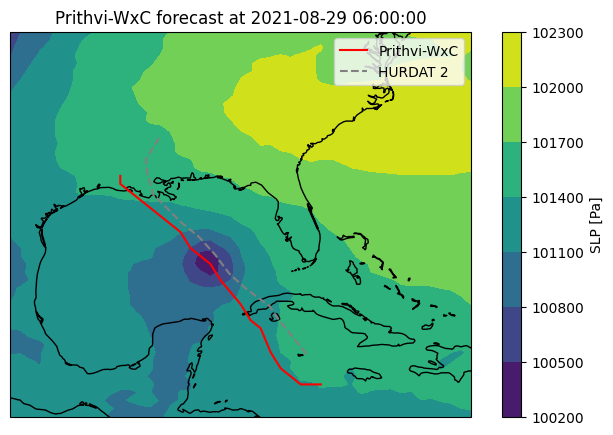

In [12]:
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 5))

step = 8
valid_time = valid_times[step].astype("datetime64[s]").item()

ax = fig.add_subplot(1, 1, 1, projection=crs)
m = ax.contourf(lons, lats, slp_fcst[step])
ax.plot(track[:, 0], track[:, 1], c="red", label="Prithvi-WxC")
ax.plot(hurdat.lon, hurdat.lat, ls="--", color="grey", label="HURDAT 2")
ax.set_title(valid_time.strftime("Prithvi-WxC forecast at %Y-%m-%d %H:%M:%S"))

ax.coastlines()
ax.legend()

plt.colorbar(m, label="SLP [Pa]", ax=ax)